<a href="https://www.kaggle.com/code/averma111/pss3e17-binary-classification-pytorch?scriptVersionId=133953479" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [342]:
import numpy as np 
import pandas as pd 
import os
import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,Dataset
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

### Directory listing

In [343]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


### Generic Pytorch Methods

In [344]:
class GenericPytorch(object):
    
    def __init__(self,model,loss_fun,optimizer):
        self.model = model
        self.loss_fun = loss_fun 
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        
        ## Placeholders 
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        #Variables 
        self.losses =[]
        self.val_losses = []
        self.total_epoch = 0
        
        #Helper Function
        self.train_step_fun = self._make_train_step_fun()
        self.val_step_fun = self._make_val_step_fun()
        
    def to(self,device):
        try:
            self.device = device
            self.model.to(self.device)
            
        except RuntimeError:
            self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
            print(f'Could not send it {device}, sending it to {self.device} instead')
            self.model.to(self.device)
            
    
    def set_loaders(self,train_loader,val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        
    def set_tensorboard(self,name,folder='runs'):
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')
        
    def _make_train_step_fun(self):
        
        def perform_train_step_fun(X,y):
            # Set the model to train 
            self.model.train()
            #Step 1 - Forward pass / make  predictions
            yhat = self.model(X)
            #Step 2 - Compute loss 
            loss = self.loss_fun(yhat,y)
            #Step 3 - Compute the gradients
            loss.backward()
            #Step 4 - Update the variables and set the gradient to 0
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            return loss.item()
        
        return perform_train_step_fun
            
    
    def _make_val_step_fun(self):
        
        def perform_val_step_fun(X,y):
            # Set the model to train 
            self.model.eval()
            #Step 1 - Forward pass / make  predictions
            yhat = self.model(X)
            #Step 2 - Compute loss 
            loss = self.loss_fun(yhat,y)
            
            return loss.item()
        
        return perform_val_step_fun
    
    
    def _mini_batch(self,validation=False):
        
        if validation:
            data_loader = self.val_loader
            step_fun = self.val_step_fun
        else:
            data_loader = self.train_loader
            step_fun = self.train_step_fun
        
        if data_loader is None:
            return None
        
        # Loop mini-batch 
        mini_batch_losses =[] 
        for x_batch,y_batch  in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            
            mini_batch_loss = step_fun(x_batch,y_batch.unsqueeze(1))
            mini_batch_losses.append(mini_batch_loss)
            
        loss = np.mean(mini_batch_losses)
        
        return loss
    
    def set_seed(self,seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        
    
    def train(self,n_epochs,seed=42):
        #Reproducibility
        self.set_seed(seed)
        
        for epoch in range(n_epochs):
            self.total_epoch +=1
            
            #inner loop perform training using mini_batch
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)
            
            #Validation 
            with torch.no_grad():
                #Perform evaluation using mini-batch
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
                
            #SummaryWriter 
            if self.writer:
                scalars ={
                    'training':loss}
                if val_loss is not None:
                    scalars.update({'validation':val_loss})
                    
                #Record both losses for each epoch
                self.writer.add_scalars(main_tag='loss',tag_scalar_dict=scalars,global_step=epoch)
                
                
        if self.writer:
            #Flush the writer 
            self.writer.flush()
        
    
    def save_checkpoint(self,filename):
        #Build the dictionary with all the elements for resuming training
        checkpoint = {
            'epoch':self.total_epoch,
            'model_state_dict':self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.losses,
            'val_loss': self.val_losses
        }
        
        torch.save(checkpoint,filename)
        
    
    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))
        

###  Data preparation

In [345]:
class Datapreparation(object):
    
    def __init__(self,root_path):
        self.root_path = root_path
        
    def get_dataframe(self,filename):
        return pd.read_csv(os.path.join(self.root_path,filename))
    
    def summary(self,text, df):
        summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
        summary['null'] = df.isnull().sum()
        summary['unique'] = df.nunique()
        summary['min'] = df.min()
        summary['median'] = df.median()
        summary['max'] = df.max()
        summary['mean'] = df.mean()
        summary['std'] = df.std()
        summary['duplicate'] = df.duplicated().sum()
        return summary
    
    def rename_column(self,df):
        updated_df=df.rename(columns=
                             {"Product ID": "Product_ID", 
                              "Air temperature [K]": "Air_temperature",
                             "Process temperature [K]":"Process_temperature",
                             "Rotational speed [rpm]":"Rotational_speed",
                             "Torque [Nm]":"Torque",
                             "Tool wear [min]":"Tool_wear",
                             "Machine failure":"Machine_failure"}
                            )
        return updated_df
    
    def set_label(self,df):
        self.label = 'Machine_failure'
        return df[self.label]
    
    def set_feature(self,df):
        df['TWF'] = df['TWF']+ df['HDF']+df['PWF']+df['OSF']+df['RNF']
        encoded_df=pd.get_dummies(df,columns=['Type']) #One-hot encoding
        df_updated=encoded_df.drop(columns=['HDF','PWF','OSF','RNF'],axis=1)
        return df_updated
    
    
    def random_split_data(self,X,y):
        return train_test_split(X, y,test_size=0.20,random_state=42)

 
    def standardization_data(self,X_data):
        scaler = StandardScaler()
        std_X_data = scaler.fit_transform(X_data)
        return std_X_data
    

    
data = Datapreparation('/kaggle/input/playground-series-s3e17')
train=data.get_dataframe('train.csv')
train = data.rename_column(train)


### Data Summary

In [346]:
data.summary('train',train)

,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,136429,0,68214.0,136428,68214.000000,39383.804275,0
Product_ID,object,0,9976,H29424,NaN,M24859,NaN,NaN,0
Type,object,0,3,H,NaN,M,NaN,NaN,0
Air_temperature,float64,0,95,295.3,300.0,304.4,299.862776,1.862247,0
Process_temperature,float64,0,81,305.8,310.0,313.8,309.941070,1.385173,0
Rotational_speed,int64,0,952,1181,1493.0,2886,1520.331110,138.736632,0
Torque,float64,0,611,3.8,40.4,76.6,40.348643,8.502229,0
Tool_wear,int64,0,246,0,106.0,253,104.408901,63.965040,0
Machine_failure,int64,0,2,0,0.0,1,0.015744,0.124486,0
TWF,int64,0,2,0,0.0,1,0.001554,0.039389,0


### Distribution Plots

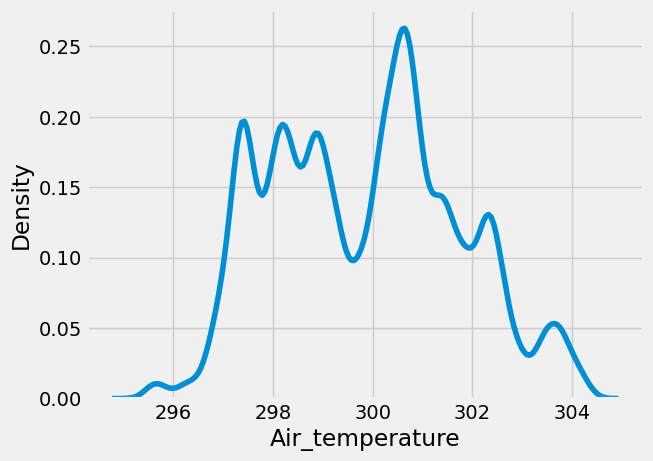

In [347]:
class Plotdata(object):
    
    def plot_kde_data(self,df,field):
        sns.kdeplot(data=df[field])
        
    def count_plot(self,df,field):
        sns.countplot(x=df[field])
        
 
plot = Plotdata()
plot.plot_kde_data(train,'Air_temperature')

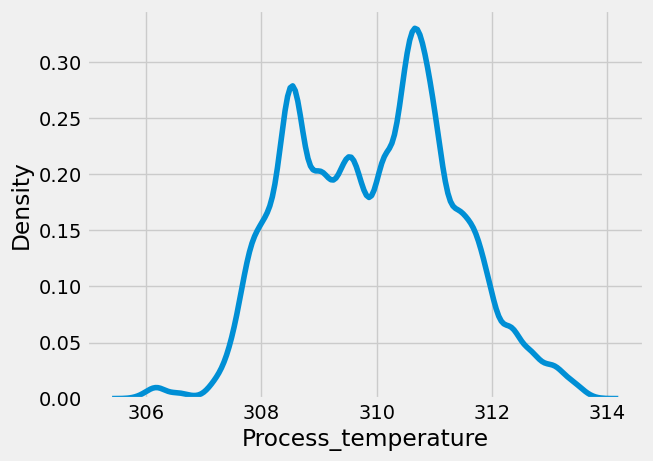

In [348]:
plot.plot_kde_data(train,'Process_temperature')

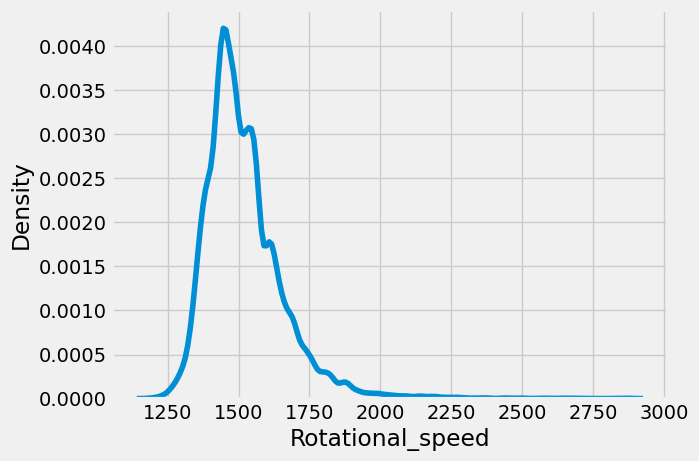

In [349]:
plot.plot_kde_data(train,'Rotational_speed')

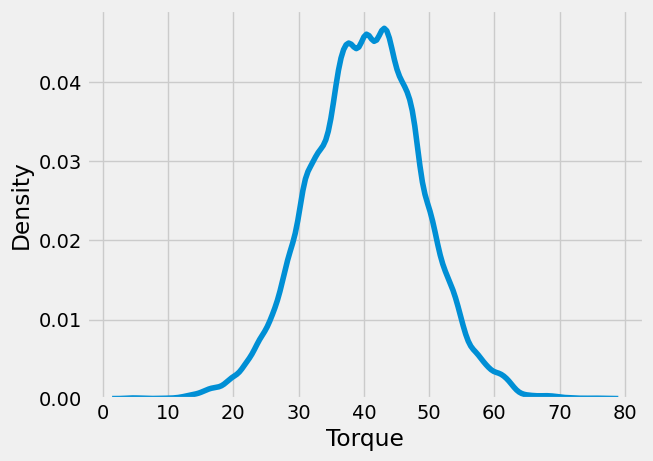

In [350]:
plot.plot_kde_data(train,'Torque')

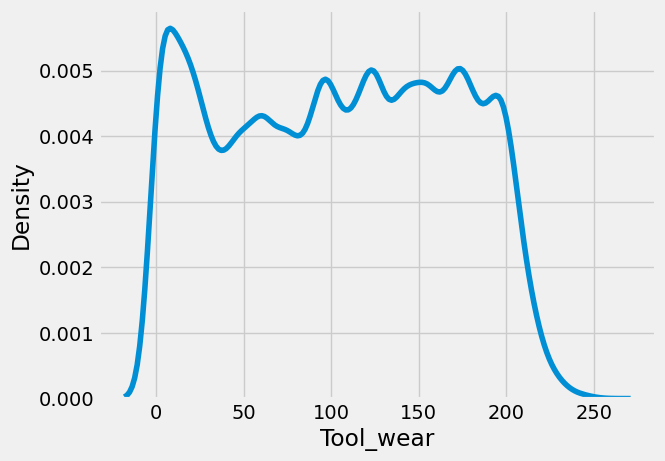

In [351]:
plot.plot_kde_data(train,'Tool_wear')

### Count Plots

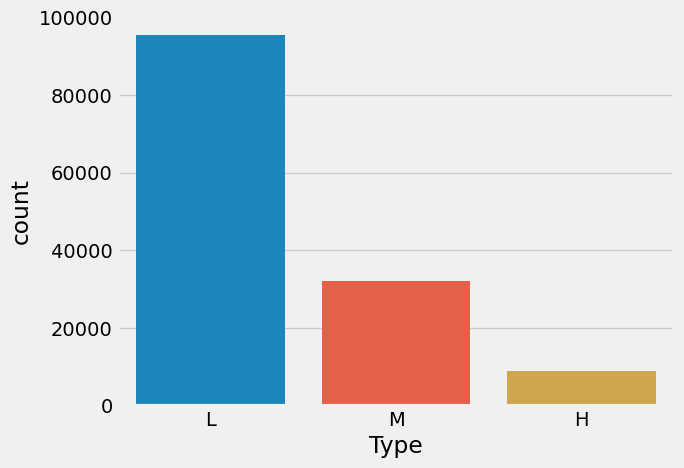

In [352]:
plot.count_plot(train,'Type')

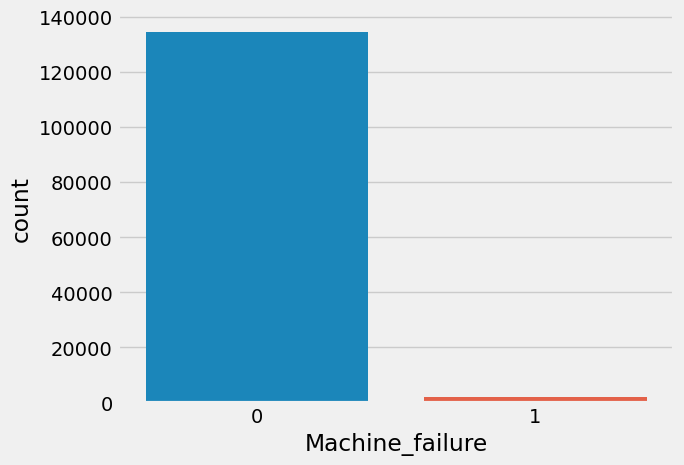

In [353]:
plot.count_plot(train,'Machine_failure')

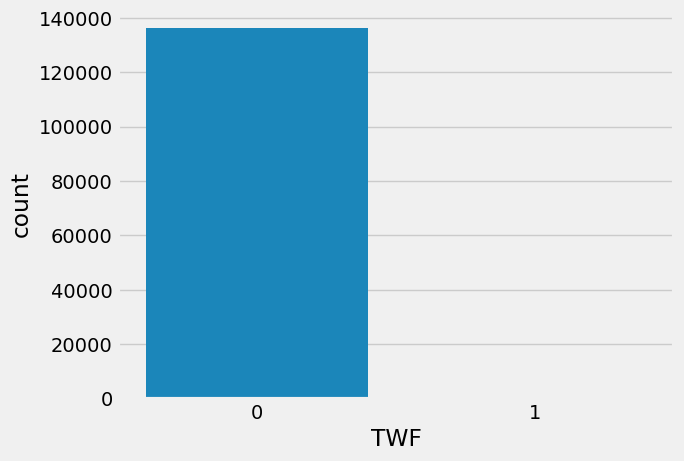

In [354]:
plot.count_plot(train,'TWF')

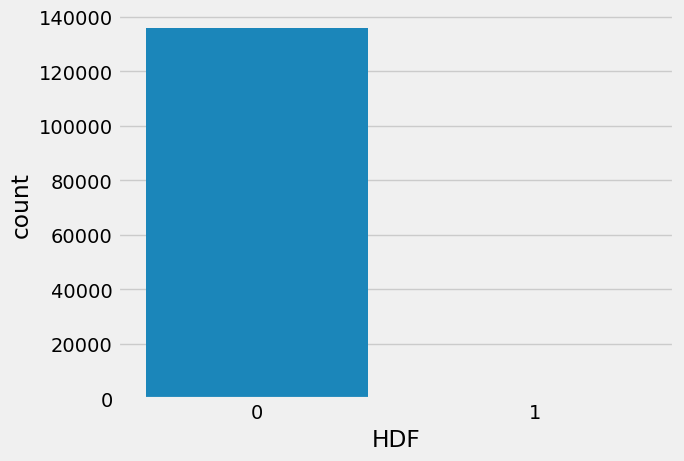

In [355]:
plot.count_plot(train,'HDF')

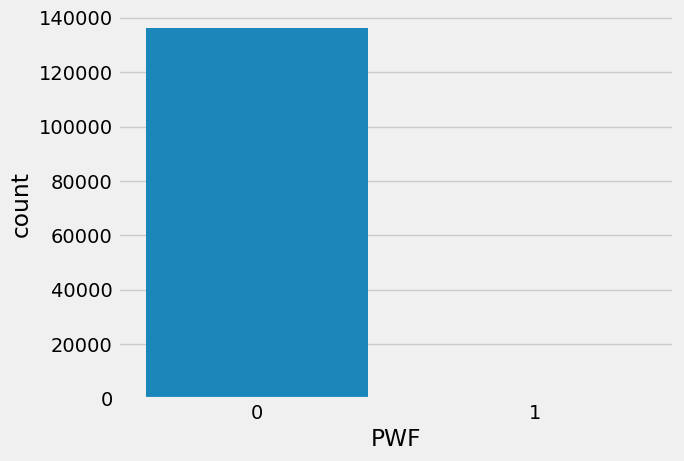

In [356]:
plot.count_plot(train,'PWF')

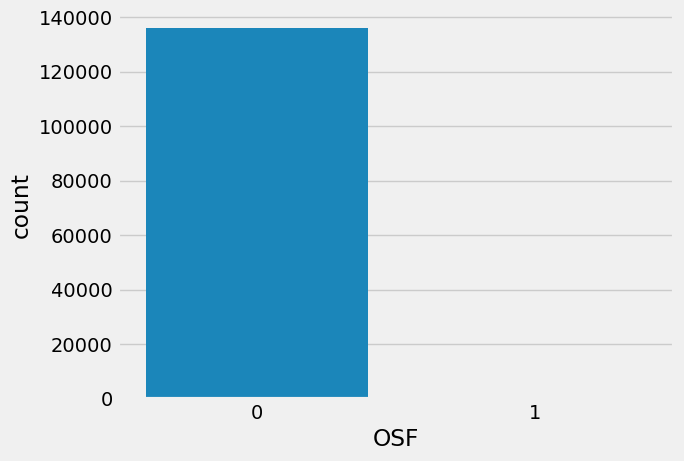

In [357]:
plot.count_plot(train,'OSF')

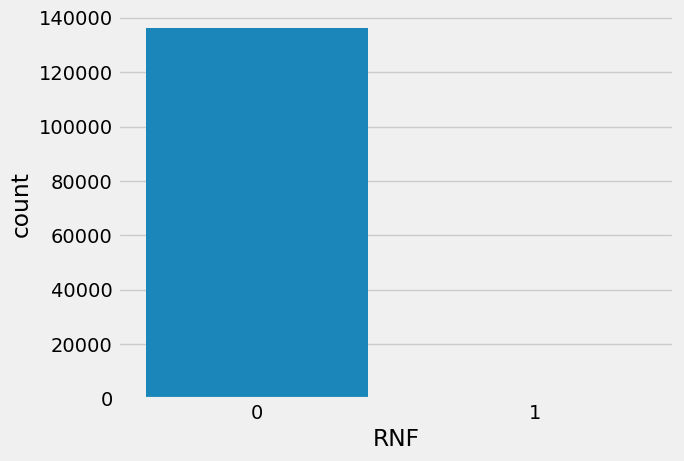

In [358]:
plot.count_plot(train,'RNF')

In [359]:
train_updated = data.set_feature(train)
train_updated.drop(columns=['id','Product_ID','Machine_failure'],axis=1,inplace=True)
train_updated.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,Type_H,Type_L,Type_M
0,300.6,309.6,1596,36.1,140,0,0,1,0
1,302.6,312.1,1759,29.1,200,0,0,0,1
2,299.3,308.5,1805,26.5,25,0,0,1,0
3,301.0,310.9,1524,44.3,197,0,0,1,0
4,298.0,309.0,1641,35.4,34,0,0,0,1


In [360]:
y = data.set_label(train)
X_train,X_val,y_train,y_val = data.random_split_data(train_updated,y)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(109143, 9) (27286, 9) (109143,) (27286,)


### Data Standardization

In [361]:
std_X_train = data.standardization_data(X_train)
std_X_val = data.standardization_data(X_val)
print(std_X_train[0],std_X_val[0])

[ 0.87940714  0.54616106 -0.28266899  0.39466237 -0.42618349 -0.11656948
 -0.26514568  0.65799864 -0.5564978 ] [ 0.55709134  0.55486145 -1.09958745  2.54057024 -1.45873853  7.3806796
 -0.26210323  0.64964191 -0.5503925 ]


### Generic Tensor operations

In [392]:
class Tensoroperations():
    
    def __init__(self):
        super(Tensoroperations,self).__init__()
    
    def convert_to_tensor(self,X,y=None):
        X_tensor = torch.as_tensor(X).float()
        y_tensor = torch.as_tensor(y).float()
        return X_tensor,y_tensor
        
    def convert_to_test_tesnor(self,X):
        X_tensor = torch.as_tensor(X).float()
        return X_tensor
    
    def get_dataloaders(self,train_dataset,val_dataset):
        train_loaders = DataLoader(train_dataset,batch_size=32,shuffle=True)
        val_loaders = DataLoader(val_dataset,batch_size=32)
        return train_loaders,val_loaders
    
    def get_test_dataloaders(self,test_dataset):
        test_loaders = DataLoader(test_dataset,batch_size=32)
        return test_loaders
        
        
    
tenops = Tensoroperations()    

In [363]:
class CustomDataset(Dataset):
    
    def __init__(self,X_data,y_data=None,is_train=True):
        super().__init__()
        if is_train:
            self.X_data = X_data
            self.y_data = y_data
        else:
            self.X_data=X_train
            
    def __getitem__(self,index):
        return (self.X_data[index],self.y_data[index])
    
    def __len__(self):
        return len(self.X_data)



### Preparing tensors

In [364]:
X_tensor_train,y_tensor_train = tenops.convert_to_tensor(std_X_train,y_train.values)
X_tensor_val,y_tensor_val = tenops.convert_to_tensor(std_X_val,y_val.values)
print('The training tensor\n',X_tensor_train,y_tensor_train)
print('The validation tensor\n',X_tensor_val,y_tensor_val)

The training tensor
 tensor([[ 0.8794,  0.5462, -0.2827,  ..., -0.2651,  0.6580, -0.5565],
        [ 0.4495, -0.3200, -0.4918,  ..., -0.2651,  0.6580, -0.5565],
        [-0.7329, -0.6088, -1.1192,  ..., -0.2651, -1.5198,  1.7970],
        ...,
        [ 0.6644,  0.5462, -0.1817,  ..., -0.2651, -1.5198,  1.7970],
        [ 0.5032,  1.0514,  0.5395,  ...,  3.7715, -1.5198, -0.5565],
        [ 0.1807, -0.1035,  4.4771,  ...,  3.7715, -1.5198, -0.5565]]) tensor([0., 0., 0.,  ..., 0., 0., 0.])
The validation tensor
 tensor([[ 0.5571,  0.5549, -1.0996,  ..., -0.2621,  0.6496, -0.5504],
        [ 0.3430,  0.9883,  0.1592,  ..., -0.2621,  0.6496, -0.5504],
        [ 0.3965,  0.3382, -0.1573,  ..., -0.2621,  0.6496, -0.5504],
        ...,
        [ 0.8782,  0.4104,  0.0944,  ..., -0.2621,  0.6496, -0.5504],
        [ 1.3064,  0.9883, -0.9701,  ..., -0.2621,  0.6496, -0.5504],
        [ 0.8782,  0.4104,  0.5188,  ..., -0.2621,  0.6496, -0.5504]]) tensor([1., 0., 0.,  ..., 0., 0., 0.])


In [365]:
train_dataset = CustomDataset(X_tensor_train,y_tensor_train)
val_dataset = CustomDataset(X_tensor_val,y_tensor_val)

### Data Loaders

In [366]:
train_loaders,val_loaders=tenops.get_dataloaders(train_dataset,val_dataset)
print(next(iter(train_loaders)))

[tensor([[ 0.2882,  0.3296, -1.6024,  2.4775,  0.0579, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [-0.5179,  0.1131, -0.1384, -0.0290,  0.6825, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [ 1.4706,  1.5567,  0.6765, -0.4761,  0.8699, -0.1166, -0.2651, -1.5198,
          1.7970],
        [ 0.3420,  1.2680,  1.3905, -1.4763,  1.4321, -0.1166, -0.2651, -1.5198,
          1.7970],
        [ 1.7930,  1.1236,  0.6332, -0.4879,  1.7913, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [ 0.7182,  0.6905,  0.3808, -0.7468, -0.7385, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [-1.4315, -1.0419, -1.1120,  1.1831, -1.3787, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [ 0.9332,  0.4018,  0.9938, -1.1821, -0.2700, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [ 0.9869, -0.0313, -0.9389,  1.0183,  1.3228, -0.1166, -0.2651, -1.5198,
          1.7970],
        [-0.4104,  0.4018, -0.0375, -0.5585,  1.1666, -0.1166,  3.7715, -1.5198,
         -0.5565],

## Model

In [367]:
class BinaryClassificationNN(torch.nn.Module):
    
    def __init__(self,in_features,out_label):
        super().__init__()
        self.layer1 = torch.nn.Linear(in_features, 16)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(16, 16)
        self.act2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(16, 16)
        self.act3 = torch.nn.ReLU()
        self.output = torch.nn.Linear(16, out_label)
        self.sigmoid = torch.nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    

binary_model = BinaryClassificationNN(X_train.shape[1],1)
print(binary_model.state_dict())

OrderedDict([('layer1.weight', tensor([[ 0.1028, -0.1148,  0.1021, -0.0694,  0.2765, -0.1976, -0.1988, -0.1988,
          0.2998],
        [ 0.1111,  0.3208, -0.2751, -0.3306, -0.2608, -0.2242,  0.1350,  0.1194,
          0.2770],
        [-0.1721, -0.2272,  0.1769, -0.1347,  0.2023, -0.0791,  0.1907, -0.2590,
         -0.1682],
        [ 0.1016,  0.0705, -0.0850,  0.1987,  0.2266, -0.2417, -0.1780,  0.3052,
         -0.1125],
        [-0.1182, -0.3225, -0.1909,  0.0833, -0.0440, -0.2420,  0.0078, -0.2277,
         -0.2828],
        [-0.1836, -0.2917, -0.2122,  0.3332,  0.0630,  0.1027, -0.3109, -0.2189,
         -0.1110],
        [ 0.0521, -0.2933, -0.1436, -0.1996,  0.0009, -0.1240, -0.0231, -0.2259,
         -0.2288],
        [-0.1945, -0.1141, -0.2631,  0.2795, -0.0662,  0.2868,  0.1039, -0.2823,
          0.2307],
        [-0.0917, -0.1278, -0.2767, -0.3314,  0.0954, -0.0728,  0.1298, -0.2736,
          0.2475],
        [-0.2447, -0.0576,  0.0696,  0.1721,  0.2691,  0.3037, -0.264

### Setting model to training mode

In [368]:
torch.manual_seed(42)
loss_fun = torch.nn.BCELoss()
optimizer = torch.optim.Adam(binary_model.parameters(), lr=0.0001)


gpy = GenericPytorch(binary_model,loss_fun,optimizer)
gpy.set_loaders(train_loaders,val_loaders)
gpy.set_tensorboard('Binary_Classification')

In [369]:
print(gpy.model)

BinaryClassificationNN(
  (layer1): Linear(in_features=9, out_features=16, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Traning Model

In [370]:
gpy.train(n_epochs=200)

### Plotting the losses

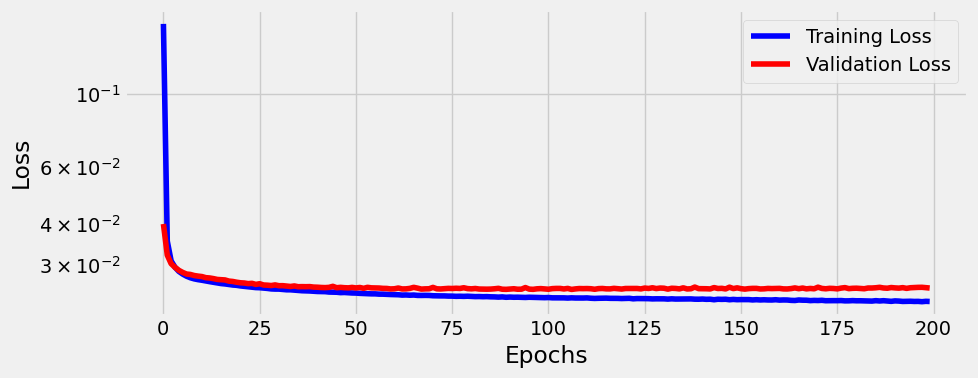

In [371]:
fig= gpy.plot_losses()

### Saving the model checkpoint

In [374]:
gpy.save_checkpoint('model_checkpoint.pth')

### Loading the model checkpoint

In [375]:
gpy.load_checkpoint('model_checkpoint.pth')

### Adding Tensorboard graphs

In [376]:
gpy.add_graph()

### Loading Tensorboard extensions

In [378]:
%load_ext tensorboard
%tensorboard --logdir runs

### Model Evaluation

In [379]:
test=data.get_dataframe('test.csv')
test = data.rename_column(test)
test.head()

,id,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [380]:
data.summary('test',test)

,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,90954,136429,181905.5,227382,181905.500000,26256.302529,0
Product_ID,object,0,9909,H29424,NaN,M24859,NaN,NaN,0
Type,object,0,3,H,NaN,M,NaN,NaN,0
Air_temperature,float64,0,92,295.3,300.0,304.4,299.859493,1.857562,0
Process_temperature,float64,0,84,305.7,310.0,313.8,309.939375,1.385296,0
Rotational_speed,int64,0,946,1168,1493.0,2886,1520.528179,139.970419,0
Torque,float64,0,595,3.8,40.5,76.6,40.335191,8.504683,0
Tool_wear,int64,0,246,0,106.0,253,104.293962,63.871092,0
TWF,int64,0,2,0,0.0,1,0.001473,0.038355,0
HDF,int64,0,2,0,0.0,1,0.005343,0.072903,0


In [381]:
test_updated = data.set_feature(test)
test_updated.drop(columns=['Product_ID'],axis=1,inplace=True)
test_updated.head()

,id,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,Type_H,Type_L,Type_M
0,136429,302.3,311.5,1499,38.0,60,0,0,1,0
1,136430,301.7,311.0,1713,28.8,17,0,0,1,0
2,136431,301.3,310.4,1525,37.7,96,0,0,1,0
3,136432,300.1,309.6,1479,47.6,5,0,0,0,1
4,136433,303.4,312.3,1515,41.3,114,0,0,0,1


In [383]:
std_X_test = data.standardization_data(test_updated)
print(std_X_test[0])

[-1.73203176  1.31383019  1.12657041 -0.15380605 -0.27457863 -0.69349379
 -0.11762742 -0.26530561  0.65859421 -0.55697187]


In [389]:
X_tensor_test = tenops.convert_to_test_tesnor(std_X_test)
print('The training tensor\n',X_tensor_train)


The training tensor
 tensor([[ 0.8794,  0.5462, -0.2827,  ..., -0.2651,  0.6580, -0.5565],
        [ 0.4495, -0.3200, -0.4918,  ..., -0.2651,  0.6580, -0.5565],
        [-0.7329, -0.6088, -1.1192,  ..., -0.2651, -1.5198,  1.7970],
        ...,
        [ 0.6644,  0.5462, -0.1817,  ..., -0.2651, -1.5198,  1.7970],
        [ 0.5032,  1.0514,  0.5395,  ...,  3.7715, -1.5198, -0.5565],
        [ 0.1807, -0.1035,  4.4771,  ...,  3.7715, -1.5198, -0.5565]])


In [390]:
class CustomDatasetTest(Dataset):
    
    def __init__(self,X_data):
        super().__init__()
        self.X_data=X_data
            
    def __getitem__(self,index):
        return self.X_data[index]
    
    def __len__(self):
        return len(self.X_data)

In [391]:
test_dataset = CustomDatasetTest(X_tensor_train)

In [393]:
test_loaders=tenops.get_test_dataloaders(test_dataset)
print(next(iter(test_loaders)))

tensor([[ 0.8794,  0.5462, -0.2827,  0.3947, -0.4262, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [ 0.4495, -0.3200, -0.4918,  0.3594, -0.3013, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [-0.7329, -0.6088, -1.1192,  1.9597, -1.2070, -0.1166, -0.2651, -1.5198,
          1.7970],
        [ 0.9332,  0.5462,  0.1645, -0.9939, -1.3787, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [-0.5179, -0.9697,  0.8135, -0.8762,  0.3078, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [ 1.3631,  0.5462, -0.8524,  1.2419, -0.5667, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [ 0.5032,  1.2680, -0.1601,  0.7241,  1.8225, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [ 1.9005,  1.7011, -0.1312, -0.1584, -0.5511, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [ 0.4495,  1.7011, -0.3620,  0.1476, -1.6286, -0.1166, -0.2651,  0.6580,
         -0.5565],
        [ 0.9332,  0.5462,  0.2222,  0.7594, -1.1289, -0.1166, -0.2651,  0.6580,
         -0.5565],
